In [1]:
## initial set up
import numpy as np

r0 = 0.02
alpha = 3
sigma = 0.01
theta0 = 0.03
beta = 1
phi = 0.05
eta = 0.005

#### Functions to compute bond price
compute B_t(T),C_t(T), A_t(T), since A_t(T) is too complicated, so we merely use numerical approximation
y_t compute yield price

In [2]:
#%%
from math import exp
B_t = lambda t,T : 1/alpha * (1 - exp(alpha*(t-T)))

C_t = lambda t,T : (exp(alpha * (t-T)) - exp(beta * (t-T))) / (alpha - beta) + (1 - exp(beta * (t-T))) / beta
'''
def A_t(t,T):
    C = 1/10000/18 * (T -2/3 + 1/6) - 0.05 * (T - 4/3) + 0.25 / 10000/2 *(1/24 - 3/8 + 1/3 + 9/8 - 3 + T)
    tau = t -T
    part1 = 1/10000/18 * (t - 2/3 * exp(3*tau) + exp(6*tau) /6)
    part2 = 0.05 * (t - 3/2 * exp(tau) + exp(3 * tau)/3)
    part3 = 0.25/10000/2 * (exp(6*tau)/24 - 3/8 * exp(4*tau) + exp(3*tau)/3 + 9/8 * exp(2*tau) - 3*exp(tau) + t)
    return C - part1 + part2 - part3
'''
##use numerial method
def A_t(t,T,dt):
    N = int(T / dt)
    A = np.zeros(N+1)
    A[N] = 0 ## end condition
    for i in np.arange(N-1,-1,-1):
        B = sigma**2/2 * B_t((i+1)*dt,T)**2
        C1 = beta * phi * C_t((i+1)*dt,T)
        C2 = eta**2/2 * C_t((i+1)*dt,T)**2
        A[i] = A[i+1] + dt * (B - C1 + C2)
        if i == int(t/dt - 1):
            break
    return A[i]

def P_t(t,T,rt,thetat):
    return exp(A_t(t,T,0.001) - B_t(t,T) * rt - C_t(t,T) * thetat)

def y_t(t,T):
    return ( A_t(t,T,0.001) -B_t(t,T) * r0 - C_t(t,T) * theta0) / (t-T)

Text(0.5,1,'Term Structure of Interest Rate')

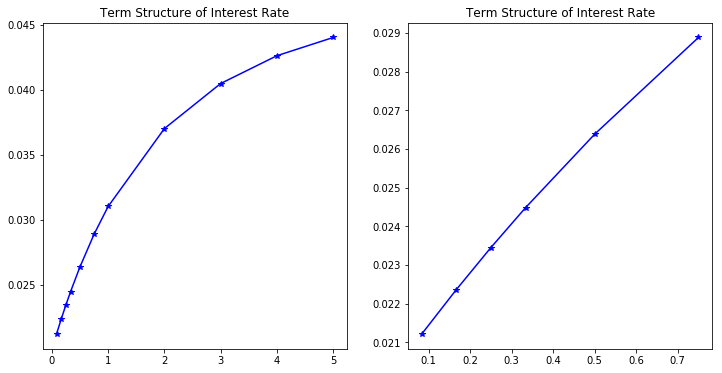

In [7]:
#%% T1 plot
import matplotlib.pyplot as plt
T_set = [1/12, 1/6, 1/4,1/3, 1/2,3/4,1,2,3,4,5]
Yield_exact = np.zeros(len(T_set))
for i in range(len(T_set)):
    Yield_exact[i] = y_t(0,T_set[i])

plt.figure(figsize = [12,6])
plt.subplot(1,2,1)
plt.plot(T_set,Yield_exact,'b*-',label = 'Yield Exact')
plt.title('Term Structure of Interest Rate')

plt.subplot(1,2,2)
plt.plot(T_set[:6],Yield_exact[:6],'b*-',label = 'Yield Exact')
plt.title('Term Structure of Interest Rate')

#### Simulation to compute bond yield

In [9]:
def TwoFactor_Vasicek(parameters,T, m, deltat = None, random = 1):
    '''
    parameters is parameter set
    T,deltat is total time and time step
    m is the number of path 
    random is random seed state
    '''
    r0 = parameters[0]; alpha = parameters[1]; sigma = parameters[2]
    theta0 = parameters[3]; beta = parameters[4]; phi = parameters[5]
    eta = parameters[6]
    if deltat == None:
        n = 1000
        deltat = T / n
    else:
        n = int(T / deltat)
    sqrtt = np.sqrt(deltat)
    np.random.seed(7 * random); W1 = np.random.normal(size = [n,m])
    np.random.seed(9 * random); W2 = np.random.normal(size = [n,m])
    r = np.zeros([n+1,m]); theta = np.zeros([n+1,m]) ## each column is a path, each row is a time index
    r[0,:] = r0; theta[0,:] = theta0
    ## simulate path of theta and r
    for i in range(0,n):
        theta[i+1,:] = theta[i,:] + beta * (phi - theta[i,:]) * deltat + eta * W2[i,:] * sqrtt
        
        r[i+1,:] = r[i,:] + alpha * (theta[i,:] - r[i,:]) * deltat + sigma * W1[i,:] * sqrtt
     
    ## compute integral of r from starting to ending
    BondPrice = np.exp(-r[:-1,:].sum(axis = 0) * deltat).mean()
    BondYield = -np.log(BondPrice) / T
    return BondYield

#### Compute Confidence Interval
For each T, simulate the BondYield 500 times and use 5%,95% number as its lower and upper bound, the interval is very tight.

In addition, by changing the 'parameters' we are able to investgate the effect of each parameter.

In [10]:
parameters = [r0,alpha,sigma,theta0,beta,phi,eta]
T_set = [1/12, 1/6, 1/4,1/3, 1/2,3/4, 1,2,3,4,5]
BondYield_set = np.zeros([3,len(T_set)])

for j in range(len(T_set)):
    print('---T = %0.4f---' % T_set[j])
    temp = []
    for i in range(500):
        Yield = TwoFactor_Vasicek(parameters, T_set[j],1000,random = i+1)
        temp.append(Yield)
    lower = np.percentile(temp,5)
    upper = np.percentile(temp,95)
    mean = np.mean(temp)
    print('Bond Yield interval: %0.5f %0.5f %0.5f' % (lower, mean, upper) )
    BondYield_set[0,j] = lower
    BondYield_set[1,j] = mean
    BondYield_set[2,j] = upper

---T = 0.0833---
Bond Yield interval: 0.02113 0.02121 0.02129
---T = 0.1667---
Bond Yield interval: 0.02226 0.02236 0.02247
---T = 0.2500---
Bond Yield interval: 0.02333 0.02345 0.02357
---T = 0.3333---
Bond Yield interval: 0.02435 0.02448 0.02461
---T = 0.5000---
Bond Yield interval: 0.02624 0.02638 0.02652
---T = 0.7500---
Bond Yield interval: 0.02874 0.02888 0.02903
---T = 1.0000---
Bond Yield interval: 0.03087 0.03102 0.03117
---T = 2.0000---
Bond Yield interval: 0.03688 0.03702 0.03715
---T = 3.0000---
Bond Yield interval: 0.04036 0.04048 0.04061
---T = 4.0000---
Bond Yield interval: 0.04250 0.04262 0.04274
---T = 5.0000---
Bond Yield interval: 0.04391 0.04402 0.04414


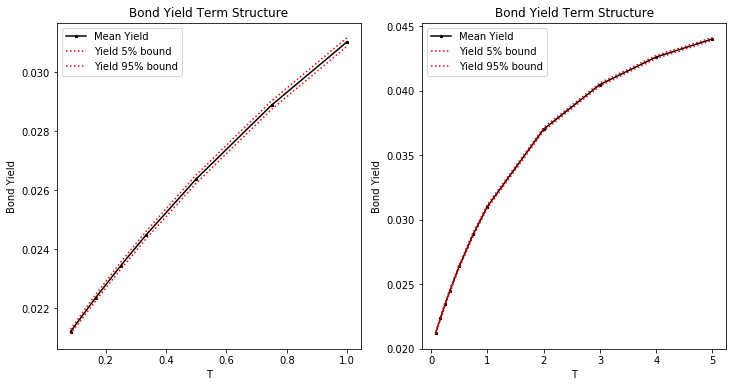

In [11]:
#%% plot of Bond Yield
plt.figure(figsize = [12,6])
plt.subplot(1,2,1)
plt.plot(T_set[:7], BondYield_set[1,:7], 'k*-',label = 'Mean Yield',markersize = 3)
plt.plot(T_set[:7], BondYield_set[0,:7], 'r:',label = 'Yield 5% bound')
plt.plot(T_set[:7], BondYield_set[2,:7],  'r:' ,label = 'Yield 95% bound')
plt.title('Bond Yield Term Structure')
plt.xlabel('T')
plt.ylabel('Bond Yield')
plt.legend()
#%%
plt.subplot(1,2,2)
plt.plot(T_set, BondYield_set[1,:], 'k*-',label = 'Mean Yield',markersize = 3)
plt.plot(T_set, BondYield_set[0,:], 'r:',label = 'Yield 5% bound')
plt.plot(T_set, BondYield_set[2,:],  'r:' ,label = 'Yield 95% bound')
plt.title('Bond Yield Term Structure')
plt.xlabel('T')
plt.ylabel('Bond Yield')
plt.legend()

#### Functions to compute bond option price
Based on analytical expression, we define function BondOptionPrice to compute the exact bond option price

Based on simulation, we are able to approximate the price using TwoFactor_BondOption

In [12]:
#%% T4 exact
import scipy.integrate as si
from scipy.stats import norm
T1 = 1; T2 = 3;
def sigmaBar(t,T1,T2):
    betat = B_t(t,T2) - B_t(t,T1)
    gammat = C_t(t,T2) - C_t(t,T1)
    sigmaBar_t = (betat*sigma) **2 + (gammat * eta)**2
    return sigmaBar_t

def BondOptionPrice(K,t,T1,T2):
    Omega = np.sqrt(si.quad(sigmaBar,t,T1,args = (T1,T2))[0])
    g0 = P_t(t,T2,r0,theta0) / P_t(t,T1,r0,theta0)
    d1 = (np.log(g0/K) + 0.5*Omega**2) / Omega
    d2 = (np.log(g0/K) - 0.5*Omega**2) / Omega
    f0 = P_t(t,T1,r0,theta0) * (g0 * norm.cdf(d1) - K * norm.cdf(d2))
    return f0

In [13]:
#%% T4 simulation
def TwoFactor_BondOption(parameters,T1,T, K, m, deltat = None, random = 1):
    '''
    parameters is parameter set
    T,deltat is total time and time step
    m is the number of path 
    K is strike price
    random is random seed state
    '''
    r0 = parameters[0]; alpha = parameters[1]; sigma = parameters[2]
    theta0 = parameters[3]; beta = parameters[4]; phi = parameters[5]
    eta = parameters[6]
    if deltat == None:
        n = 1000
        deltat = T / n
    else:
        n = int(T / deltat)
    sqrtt = np.sqrt(deltat)
    np.random.seed(7 * random); W1 = np.random.normal(size = [n,m])
    np.random.seed(9 * random); W2 = np.random.normal(size = [n,m])
    r = np.zeros([n+1,m]); theta = np.zeros([n+1,m]) ## each column is a path, each row is a time index
    r[0,:] = r0; theta[0,:] = theta0
    ## simulate path of theta and r
    for i in range(0,n):
        theta[i+1,:] = theta[i,:] + beta * (phi - theta[i,:]) * deltat + eta * W2[i,:] * sqrtt
        
        r[i+1,:] = r[i,:] + alpha * (theta[i,:] - r[i,:]) * deltat + sigma * W1[i,:] * sqrtt
     
    ## compute integral of r from starting to ending
    price = np.exp(-(r[int(T1/deltat):-1,:]).sum(axis = 0) * deltat)
    payoff = np.where(price - K >0, price - K,0)
    return np.mean(payoff) * P_t(0,T1,r0,theta0) ## use P_0(T1) to depreciate the price

Simulate: 0.26573 Exact: 0.26569
Simulate: 0.22144 Exact: 0.22141
Simulate: 0.17716 Exact: 0.17713
Simulate: 0.13288 Exact: 0.13285
Simulate: 0.08860 Exact: 0.08856
Simulate: 0.04431 Exact: 0.04428
Simulate: 0.00229 Exact: 0.00128
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000
Simulate: 0.00000 Exact: 0.00000


Text(0.5,0,' $\\alpha$ ')

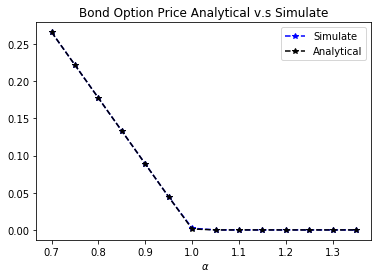

In [14]:
#%% T4 plot, prove the simulaton is close to exact expression
parameters = [r0,alpha,sigma,theta0,beta,phi,eta]
K = P_t(0,T2,r0,theta0) / P_t(0,T1,r0,theta0)
frac = np.arange(0.7,1.35,0.05)
simulate_price = np.zeros(len(frac))
exact_price = np.zeros(len(frac))
for i in range(len(frac)):
    simulate_price[i] = TwoFactor_BondOption(parameters,T1,T2, K * frac[i], 5000,deltat = 0.001)
    exact_price[i] = BondOptionPrice(K * frac[i],0,T1,T2)
    print('Simulate: %.5f Exact: %.5f' % (simulate_price[i],exact_price[i]))

plt.plot(frac,simulate_price,'b*--',label = 'Simulate')
plt.plot(frac,exact_price,'k*--',label = 'Analytical')
plt.legend()
plt.title('Bond Option Price Analytical v.s Simulate')
plt.xlabel(r' $\alpha$ ')

#### Use simulation to compute r and theta at time t0 so that we can compute the bond price in order to get  the swap_rate at t0.
Then we are able to get Annuity at t0 and strike price K which is swap_rate at time 0 so that we can compute exact Value_t0.

Then we find volatility to make the Annuity_0 * (BS alike equation) equals to V_t0

In [15]:
#%% T5 simulation to get r_t0 ,theta_t0 so that to compute Swap_rate at t0
def TwoFactor_Path(parameters,t0,T, m, deltat = None, random = 1):
    '''
    parameters is parameter set
    T,deltat is total time and time step
    m is the number of path 
    random is random seed state
    '''
    r0 = parameters[0]; alpha = parameters[1]; sigma = parameters[2]
    theta0 = parameters[3]; beta = parameters[4]; phi = parameters[5]
    eta = parameters[6]
    if deltat == None:
        n = 1000
        deltat = T / n
    else:
        n = int(T / deltat)
    sqrtt = np.sqrt(deltat)
    np.random.seed(7 * random); W1 = np.random.normal(size = [n,m])
    np.random.seed(9 * random); W2 = np.random.normal(size = [n,m])
    r = np.zeros([n+1,m]); theta = np.zeros([n+1,m]) ## each column is a path, each row is a time index
    r[0,:] = r0; theta[0,:] = theta0
    ## simulate path of theta and r
    for i in range(0,n):
        theta[i+1,:] = theta[i,:] + beta * (phi - theta[i,:]) * deltat + eta * W2[i,:] * sqrtt
        
        r[i+1,:] = r[i,:] + alpha * (theta[i,:] - r[i,:]) * deltat + sigma * W1[i,:] * sqrtt
     
    r_t0 = r[int(t0/deltat),:].mean()
    theta_t0 = theta[int(t0/deltat),:].mean()
    return [r_t0,theta_t0]

In [16]:
structure = np.arange(3.25,6,0.25)
t0 = 3;T = 6

## compute strike price K
Annuity_0 = 0
for i in range(len(structure)):
    Annuity_0 += P_t(0,structure[i],r0,theta0) * 0.25
K = (P_t(0,t0,r0,theta0) - P_t(0,T,r0,theta0)) / Annuity_0 ## today's swap rate

r_t0,theta_t0 = TwoFactor_Path(parameters,3,6,50000,deltat=0.001,random = 1) ##simulate r_t0, theta_t0

##compute swap_rate at t0
Annuity_t0 =  0
for i in range(len(structure)):
    Annuity_t0 += P_t(t0,structure[i],r_t0,theta_t0) * 0.25

swap_t0 = (P_t(t0,t0,r_t0,theta_t0) - P_t(t0,T,r_t0,theta_t0)) / Annuity_t0

##get value at t0
V_t0 = Annuity_t0 * max(swap_t0 - K,0)

In [17]:
#%% Used to find implied volatility
n = norm.pdf
N = norm.cdf
def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if cp_flag == 'c':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*n(d1)

def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-20

    sigma = 0.5
    for i in np.arange(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)

        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            print(sigma, price,diff)
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [18]:
## find implied volatility 
V_t0 = Annuity_t0 * max(swap_t0 - K,0)
find_vol(V_t0/Annuity_0,'c',K,K,t0,r=0 )    ## 0.00057775

0.0005777497426981432

E:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
E:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
E:\Software\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
E:\Software\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
E:\Software\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
E:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
E:\Software\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid

0.0007227274426937694 7.810064865350378e-21 -7.810064865350378e-21
0.0014232298965475858 7.718832023248651e-21 -7.718832023248651e-21
0.0021010608284043487 5.450055990499987e-21 -5.450055990499987e-21
0.0034441045783265697 5.618625669721098e-21 -5.618625669721098e-21
0.004081360570723767 3.9024659987930246e-21 -3.9024659987930246e-21
0.0047638627292412574 6.579078083253407e-21 -6.579078083253407e-21
0.005409659895489774 6.673445689264721e-21 -6.673445689264721e-21
0.006009748095576169 4.282234133641236e-21 -4.282234133641236e-21
0.006672277244993368 6.2595132381254615e-21 -6.2595132381254615e-21


Text(0.5,0,'$\\alpha (* K)$')

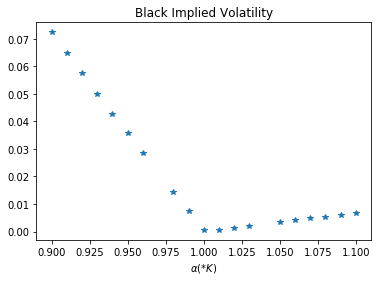

In [19]:
#%% T5 plot, I don't know why there are some nans
ffrac = np.arange(0.9,1.1,0.01)
implied_vol = np.zeros(len(ffrac))
for i in range(len(ffrac)):
    V_t0 = Annuity_t0 * max(swap_t0 - K* ffrac[i],0)
    implied_vol[i] = find_vol(V_t0 / Annuity_0, 'c',K,K*ffrac[i],t0,0)

plt.plot(ffrac,implied_vol,'*')
plt.title('Black Implied Volatility')
plt.xlabel(r'$\alpha (* K)$')